In [1]:
from Network import Generator, Discriminator
import Utils
from keras.applications.vgg19 import VGG19

import keras.backend as K
from keras.models import Model
from keras.layers import Input, Lambda, Add, Concatenate
from keras.optimizers import Adam
from keras.layers.core import Activation
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.layers.normalization import BatchNormalization
from keras.models import load_model

from skimage import data, io
from PIL import Image
from matplotlib import pyplot as plt
from tqdm import tqdm, tqdm_notebook
import numpy as np

Using TensorFlow backend.


In [2]:
# how many times the original image is scaled down
downscale_factor = 4
# expected output size
output_image_shape = (1920,1080,3)

input_image_shape = (480,270,3)

## Res block

In [3]:
def res_block_gen(model, kernal_size, filters, strides):
    
    gen = model
    
    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)
    # Using Parametric ReLU
    model = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(model)
    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)
        
    model = Add()([gen, model])
    
    return model

## Upsampling block

In [4]:
def up_sampling_block(model, kernal_size, filters, strides):
    
    model = Conv2DTranspose(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = LeakyReLU(alpha = 0.2)(model)
    #model = PReLU(shared_axes=[1,2,3])(model)
    
    return model

## Loss function

In [5]:
class VGG_MSE_LOSS(object):

    def __init__(self, image_shape, orig_rate = 0.1):
        
        self.image_shape = image_shape
        self.orig_rate = orig_rate

    # computes VGG loss or content loss
    def loss(self, y_true, y_pred):
    
        vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=self.image_shape)
        vgg19.trainable = False
        # Make trainable as False
        for l in vgg19.layers:
            l.trainable = False
        model = Model(inputs=vgg19.input, outputs=vgg19.get_layer('block5_conv4').output)
        model.trainable = False
        
        return K.mean(K.square(model(y_true) - model(y_pred))) + self.orig_rate * K.mean(K.square(y_true - y_pred))

In [6]:
class VGG_LOSS(object):

    def __init__(self, image_shape):
        
        self.image_shape = image_shape

    # computes VGG loss or content loss
    def loss(self, y_true, y_pred):
    
        vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=self.image_shape)
        vgg19.trainable = False
        # Make trainable as False
        for l in vgg19.layers:
            l.trainable = False
        model = Model(inputs=vgg19.input, outputs=vgg19.get_layer('block5_conv4').output)
        model.trainable = False
        
        return K.mean(K.square(model(y_true) - model(y_pred)))

## Generator

In [7]:
def make_upscaler(input_shape):
        
    upscaler_input = Input(shape = input_image_shape)

    model = Conv2D(filters = 64, kernel_size = 9, strides = 1, padding = "same")(upscaler_input)
    model = PReLU(shared_axes=[1,2])(model)

    upsc_model = model

    for index in range(16):
        model = res_block_gen(model, 3, 64, 1)

    model = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)
    model = Add()([upsc_model, model])

    for index in range(2):
        model = up_sampling_block(model, 3, 192, 2)
    
    resized_input = (Lambda(lambda x: K.resize_images(x, 4, 4, "channels_last", "bilinear")))(upscaler_input)
    model = Concatenate(axis = 3)([resized_input, model])

    model = Conv2D(filters = 3, kernel_size = 9, strides = 1, padding = "same")(model)
    model = Activation('tanh')(model)

    upscaler_model = Model(inputs = upscaler_input, outputs = model)

    return upscaler_model

## Data

In [8]:
input_dir = '../images/photo_fullhd'
model_save_dir = 'trained_model'
number_of_images = 1000
train_test_ratio = 0.8

In [9]:
x_train_lr, x_train_hr, x_test_lr, x_test_hr = Utils.load_training_data(input_dir, '.jpg', number_of_images, train_test_ratio, downscale_factor, prog_func=tqdm_notebook) 

## Model

In [48]:
upscaler = make_upscaler(input_image_shape)

In [49]:
input_layer = Input(shape=input_image_shape)
upscaled_layer = upscaler(input_layer)

upscaler_training_model = Model(inputs=input_layer, outputs=upscaled_layer)

In [50]:
#upscale_model.compile(loss="mean_squared_error", optimizer=Adam())

In [51]:
vgg_loss = VGG_MSE_LOSS(output_image_shape, 0.01).loss

In [52]:
upscaler_training_model.compile(loss=vgg_loss, optimizer=Adam())

In [53]:
batch_count = 10001
batch_size = 1

loss_file_name = 'losses_skip_con_test.txt'
model_file_name_tpl = 'test_upscaler_skip_con_%06db.h5'
model_save_batches = 500

agg_loss = None
loss_update_rate = 0.01

loss_file = open(model_save_dir + '/' + loss_file_name, 'w+')
loss_file.write('batch\tloss\tagg_loss\n')
loss_file.close()

for b in tqdm_notebook(range(batch_count), desc = 'Batch'):

    rand_nums = np.random.randint(0, x_train_hr.shape[0], size=batch_size)

    image_batch_hr = x_train_hr[rand_nums]
    image_batch_lr = x_train_lr[rand_nums]
    loss = upscaler_training_model.train_on_batch(image_batch_lr, image_batch_hr)

    if(agg_loss == None):
        agg_loss = loss
    else:
        agg_loss = (1 - loss_update_rate) * agg_loss + loss_update_rate * loss

    loss_file = open(model_save_dir + '/' + loss_file_name, 'a')
    loss_file.write('%d\t%f\t%f\n' %(b, loss, agg_loss) )
    loss_file.close()
    
    if(b % model_save_batches == 0):
        upscaler.save(model_save_dir + '/' + model_file_name_tpl % b)

KeyboardInterrupt: 

## Saving a model

In [67]:
upscaler.save('trained_model/test_upscaler_skip_con_custom.h5')

## Loading a model

In [10]:
upscaler = load_model('trained_model/model_upscaler_skip_con_009000b_best_till_now.h5')

W0921 11:01:36.885213 139830886205248 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0921 11:01:36.919557 139830886205248 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0921 11:01:37.053259 139830886205248 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0921 11:01:37.054158 139830886205248 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1

## Results save

In [41]:
def save_array_as_image(a, filename, quality = 100):
    a = np.uint8(np.around((a + 1) * 127.5))
    a = np.swapaxes(a, 0, 1)
    a_img = Image.fromarray(a)
    a_img.save(filename, quality = quality)

In [42]:
def rescale_save_array_as_image(a, filename, quality = 100):
    a = np.uint8(np.around((a + 1) * 127.5))
    a = np.swapaxes(a, 0, 1)
    a_img = Image.fromarray(a)
    a_img = a_img.resize((1920, 1080), Image.BICUBIC)
    a_img.save(filename, quality = quality)

In [43]:
def save_images_orig(lowres, highres, idx_start, idx_stop, prefix, quality = 100):
    
    for idx in range(idx_start, idx_stop + 1):
        ex = lowres[idx]
        rescale_save_array_as_image(ex, 'example_images/' + prefix + "_im%04d_lowres.jpg" % idx, quality)

        ex = highres[idx]
        save_array_as_image(ex, 'example_images/' + prefix + "_im%04d_orig.jpg" % idx, quality)

In [44]:
def save_images_predicted(lowres, upscaler, idx_start, idx_stop, prefix, batch, quality = 100):
    
    for idx in range(idx_start, idx_stop + 1):
        ex = upscaler.predict(lowres[[idx]])[0]
        save_array_as_image(ex, 'example_images/' + prefix + "_im%04d_upscaled_%06d.jpg" % (idx, batch), quality)

In [45]:
# save_images_orig(x_train_lr, x_train_hr, 1, 2, "tst-trn")
# save_images_predicted(x_train_lr, upscaler, 1, 2, "tst-trn", 10)

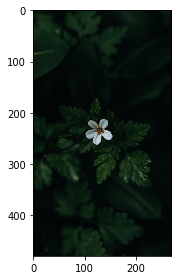

In [15]:
ex = x_train_lr[2]
rescale_save_array_as_image(ex, "example_images/skip_con_train_lowres.jpg")

ex = (ex + 1)/2
#ex = ex.swapaxes(0,1)

io.imshow(ex)

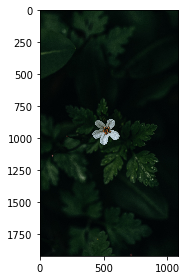

In [16]:
ex = x_train_hr[2]
save_array_as_image(ex, "example_images/skip_con_train_orig.jpg")

ex = (ex + 1)/2
#ex = ex.swapaxes(0,1)

io.imshow(ex)

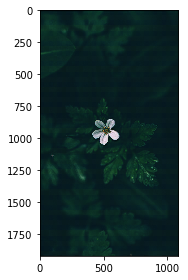

In [15]:
ex = upscaler.predict(x_train_lr[[2]])[0]
save_array_as_image(ex, "example_images/skip_con_train_upscaled.jpg")

ex = (ex + 1)/2

io.imshow(ex)

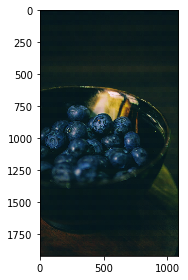

In [16]:
ex = upscaler.predict(x_test_lr[[0]])[0]
save_array_as_image(ex, "example_images/skip_con_test_upscaled.jpg")

ex = (ex + 1)/2

io.imshow(ex)

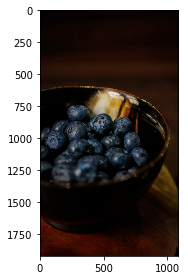

In [19]:
ex = x_test_hr[0]
save_array_as_image(ex, "example_images/skip_con_test_orig.jpg")

ex = (ex + 1)/2
#ex = ex.swapaxes(0,1)

io.imshow(ex)

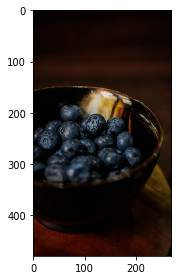

In [20]:
ex = x_test_lr[0]
rescale_save_array_as_image(ex, "example_images/skip_con_test_lowres.jpg")

ex = (ex + 1)/2
#ex = ex.swapaxes(0,1)

io.imshow(ex)